# Dimensionality Reduction Evaluation
C. Heiser, 2019

---
__The purpose of this notebook is to evaluate dimensionality reduction techniques for their ability to preserve Euclidean structure of high-dimensional datasets.__  
  
To benchmark these techniques, we are using two single-cell RNAseq datasets:
* From [__Macosko, *et al* (2015)__](https://www.ncbi.nlm.nih.gov/pubmed/26000488), the mouse retina scRNA-seq data generated using DropSeq: [GSM1626793](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM1626793)
* From [__Herring, *et al* (2018)__](https://www.ncbi.nlm.nih.gov/pubmed/29153838), the WT mouse colon scRNA-seq data generated using inDrops: [GSM2743164](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM2743164)  
  
The first set should be __discrete__, containing highly separable cell populations from the mouse retina, where the latter will be __continuous__, representing a continuum of branching cell states in the gut epithelium.  
  
Both datasets have been __preprocessed and feature-selected__ to allow for direct input to downstream dimensionality reduction algorithms (rather than first performing PCA to limit dimensional input). These methods are shown in [`dev/preprocess_and_filter.ipynb`](dev/preprocess_and_filter.ipynb).

In [1]:
from fcc_DRs import *
%matplotlib inline

Using TensorFlow backend.
/home/cody/.virtualenvs/lau_lab/lib/python3.6/site-packages/kopt/config.py:60: YAMLLoadWarning: 
  *** Calling yaml.load() without Loader=... is deprecated.
  *** The default Loader is unsafe.
  *** Please read https://msg.pyyaml.org/load for full details.
  _config = yaml.load(open(_config_path))


In [16]:
# read in Macosko retina data
retina = RNA_counts.from_file('inputs/GSM1626793_P14Retina_1.processed.tsv', cells_axis=0, labels=[0,0])
# read in Herring colon data
colon = RNA_counts.from_file('inputs/GSM2743164_rep1_colon_rnaseq.processed.tsv', cells_axis=0, labels=[0,0])

In [17]:
# look at dimensions of counts matrix (cells, genes)
retina.data.shape

(1654, 500)

In [18]:
# look at dimensions of counts matrix (cells, genes)
colon.data.shape

(1653, 500)

---
### PCA
We'll look at principal component analysis (PCA) first, as a gold-standard. Because PCA performs a __linear__ transformation on the data, 500 PCs should perfectly preserve the overall dataset structure.

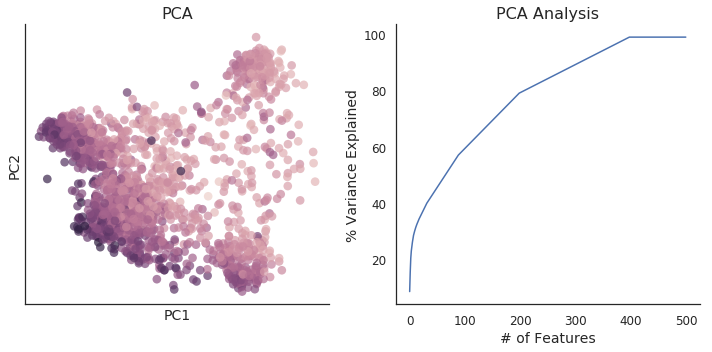

In [19]:
retina_PCA500 = fcc_PCA(retina.arcsinh_norm(), n_components=500)
retina_PCA500.plot_PCA()

We can test the Euclidean distance preservation as follows:

In [20]:
# choose value for K-nearest neighbor calculations. We use 30 because that is the standard perplexity chosen for DR techniques here.
k = 30

R: 1.0
EMD: 0.0
KLD: -0.0
Knn Pres.: 100.0


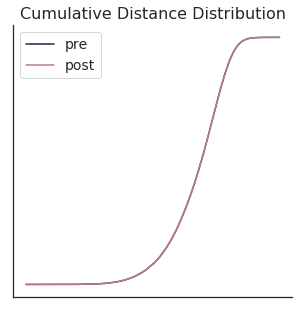

<Figure size 504x504 with 0 Axes>

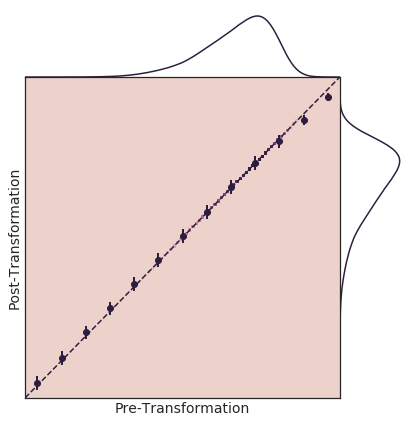

CPU times: user 1min 33s, sys: 13.5 s, total: 1min 47s
Wall time: 1min 46s


In [21]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=retina.distance_matrix(transform='arcsinh'), post=retina_PCA500.distance_matrix())
knn = knn_preservation(pre=retina.knn_graph(k, transform='arcsinh'), post=retina_PCA500.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.show()
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.show()

Now we can perform a PCA with a smaller number of components and determine the degree of information loss.  
The extreme example would be comparing only the __first two principal components__ to the original dataset:

In [22]:
# create dictionaries for dumping results into
final_distance_stats = {'Retina':{'R':{}, 'EMD':{}, 'KLD':{}, 'Knn Pres.':{}}, 'Colon':{'R':{}, 'EMD':{}, 'KLD':{}, 'Knn Pres.':{}}}

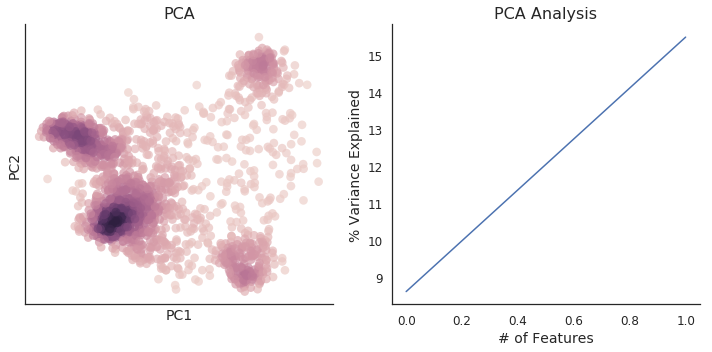

In [23]:
retina_PCA2 = fcc_PCA(retina.arcsinh_norm(), n_components=2)
retina_PCA2.plot_PCA()

R: 0.5449
EMD: 0.2848
KLD: 0.1721
Knn Pres.: 97.4315


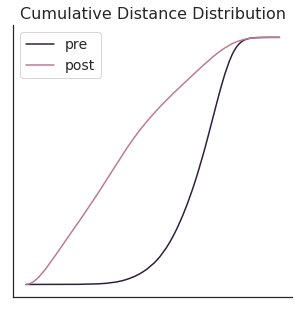

<Figure size 504x504 with 0 Axes>

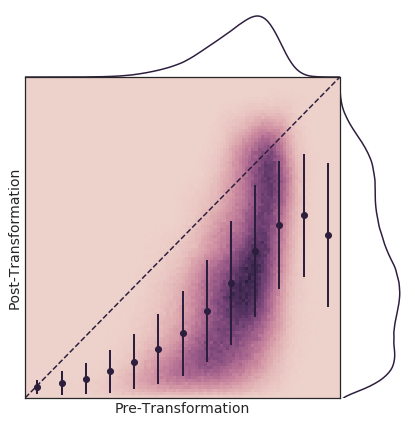

CPU times: user 1min 21s, sys: 12.5 s, total: 1min 34s
Wall time: 1min 33s
Compiler : 137 ms


In [24]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=retina.distance_matrix(transform='arcsinh'), post=retina_PCA2.distance_matrix())
knn = knn_preservation(pre=retina.knn_graph(k, transform='arcsinh'), post=retina_PCA2.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.show()
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.show()

# dump outputs into dictionary
final_distance_stats['Retina']['R']['PCA (2)'], final_distance_stats['Retina']['EMD']['PCA (2)'], final_distance_stats['Retina']['KLD']['PCA (2)'], final_distance_stats['Retina']['Knn Pres.']['PCA (2)'] = mantel_stats[0], EMD, KLD, knn

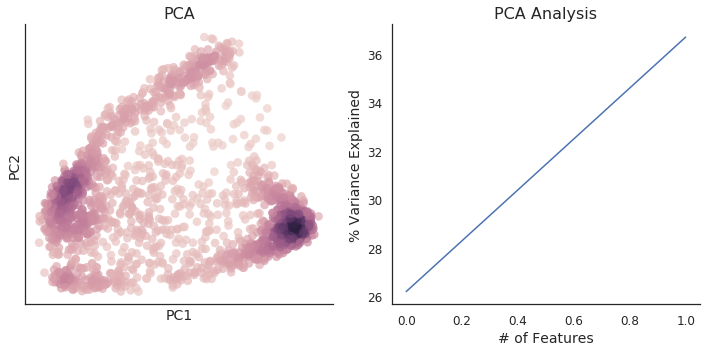

In [25]:
colon_PCA2 = fcc_PCA(colon.arcsinh_norm(), n_components=2)
colon_PCA2.plot_PCA()

R: 0.7374
EMD: 0.0872
KLD: 0.1051
Knn Pres.: 97.8163


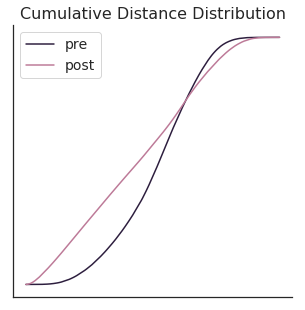

<Figure size 504x504 with 0 Axes>

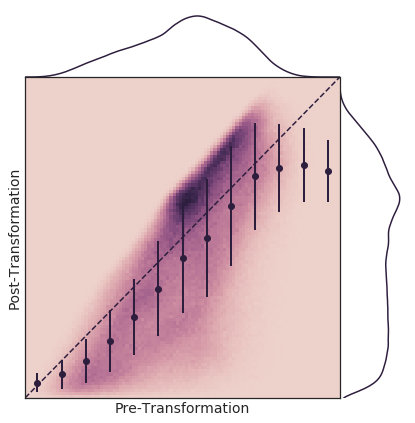

CPU times: user 1min 22s, sys: 613 ms, total: 1min 23s
Wall time: 1min 22s


In [26]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=colon.distance_matrix(transform='arcsinh'), post=colon_PCA2.distance_matrix())
knn = knn_preservation(pre=colon.knn_graph(k, transform='arcsinh'), post=colon_PCA2.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.show()
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.show()

# dump outputs into dictionary
final_distance_stats['Colon']['R']['PCA (2)'], final_distance_stats['Colon']['EMD']['PCA (2)'], final_distance_stats['Colon']['KLD']['PCA (2)'], final_distance_stats['Colon']['Knn Pres.']['PCA (2)'] = mantel_stats[0], EMD, KLD, knn

---
# t-SNE
A workhorse technique for dimensionality reduction and visualization of scRNA-seq datasets, t-SNE performs a stochastic, non-linear transformation to project high-dimensional data into 2D in order to identify clustering and global structure.  
Here, we will plug arcsinh-normalized counts data directly into t-SNE and compare results to the original, feature-selected dataset.

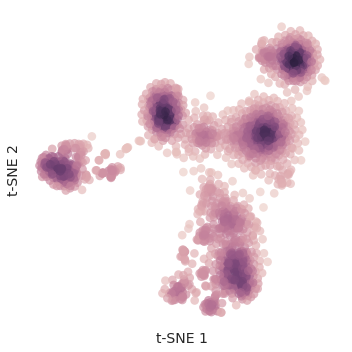

In [27]:
retina_tSNE = fcc_tSNE(retina.arcsinh_norm(), perplexity=30, seed=11)
retina_tSNE.plot()

R: 0.5351
EMD: 0.2764
KLD: 0.1626
Knn Pres.: 97.3062


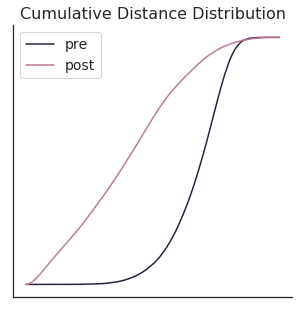

<Figure size 504x504 with 0 Axes>

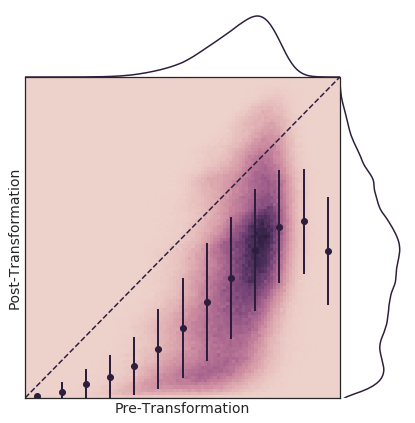

CPU times: user 1min 20s, sys: 13.3 s, total: 1min 33s
Wall time: 1min 33s


In [28]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=retina.distance_matrix(transform='arcsinh'), post=retina_tSNE.distance_matrix())
knn = knn_preservation(pre=retina.knn_graph(k, transform='arcsinh'), post=retina_tSNE.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.show()
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.show()

# dump outputs into dictionary
final_distance_stats['Retina']['R']['t-SNE'], final_distance_stats['Retina']['EMD']['t-SNE'], final_distance_stats['Retina']['KLD']['t-SNE'], final_distance_stats['Retina']['Knn Pres.']['t-SNE'] = mantel_stats[0], EMD, KLD, knn

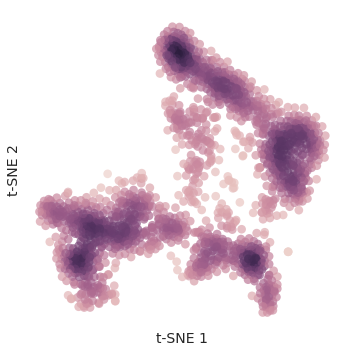

In [29]:
colon_tSNE = fcc_tSNE(colon.arcsinh_norm(), perplexity=30, seed=12)
colon_tSNE.plot()

R: 0.7469
EMD: 0.1146
KLD: 0.0872
Knn Pres.: 97.6884


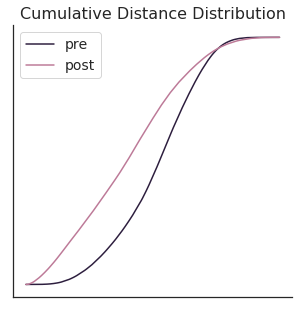

<Figure size 504x504 with 0 Axes>

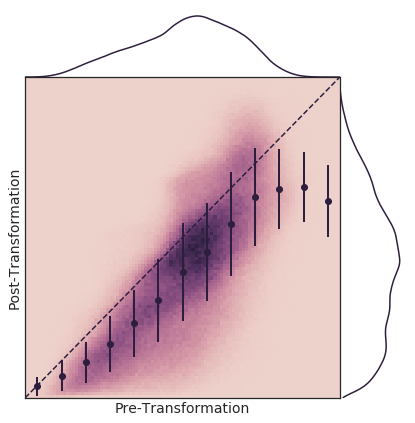

CPU times: user 1min 19s, sys: 9.83 s, total: 1min 29s
Wall time: 1min 28s


In [30]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=colon.distance_matrix(transform='arcsinh'), post=colon_tSNE.distance_matrix())
knn = knn_preservation(pre=colon.knn_graph(k, transform='arcsinh'), post=colon_tSNE.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.show()
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.show()

# dump outputs into dictionary
final_distance_stats['Colon']['R']['t-SNE'], final_distance_stats['Colon']['EMD']['t-SNE'], final_distance_stats['Colon']['KLD']['t-SNE'], final_distance_stats['Colon']['Knn Pres.']['t-SNE'] = mantel_stats[0], EMD, KLD, knn

---
# UMAP
Another popular method for low-dimensional projection of scRNA-seq datasets, UMAP creates high-dimensional manifolds that describe the structure of the dataset.  
Here, we will plug arcsinh-normalized counts data directly into UMAP and compare results to the original, feature-selected dataset.

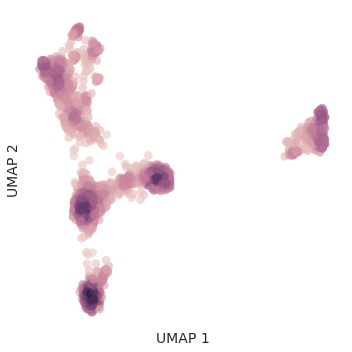

In [31]:
retina_UMAP = fcc_UMAP(retina.arcsinh_norm(), perplexity=30, seed=18)
retina_UMAP.plot()

In [42]:
retina_UMAP.plot(save_to='images/retina_density_UMAP.png', figsize=(6,6))

In [43]:
retina_UMAP.plot(color=retina.arcsinh_norm()[:,retina.gene_IDs.str.contains('Opn1mw$')].flatten(), save_to='images/retina_Opn1mw_UMAP.png', figsize=(6,6))

In [44]:
retina_UMAP.plot(color=retina.arcsinh_norm()[:,retina.gene_IDs.str.contains('Rlbp1$')].flatten(), save_to='images/retina_Rlbp1_UMAP.png', figsize=(6,6))

In [49]:
retina_UMAP.plot(color=retina.arcsinh_norm()[:,retina.gene_IDs.str.contains('Pax6$')].flatten(), save_to='images/retina_Pax6_UMAP.png', figsize=(6,6))

In [50]:
retina_UMAP.plot(color=retina.arcsinh_norm()[:,retina.gene_IDs.str.contains('Vsx2$')].flatten(), save_to='images/retina_Vsx2_UMAP.png', figsize=(6,6))

R: 0.527
EMD: 0.314
KLD: 0.2824
Knn Pres.: 97.1589


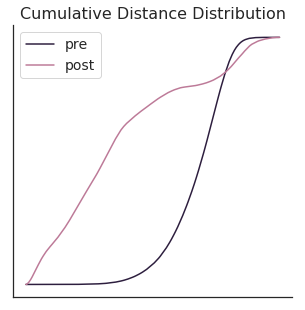

<Figure size 504x504 with 0 Axes>

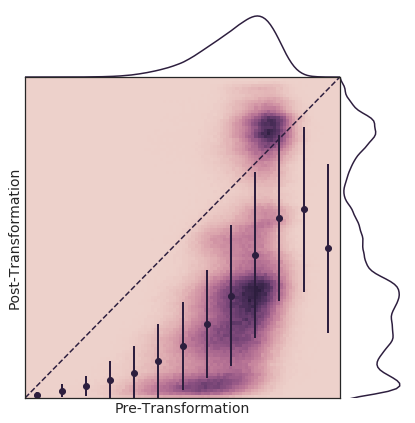

CPU times: user 1min 17s, sys: 12.9 s, total: 1min 30s
Wall time: 1min 29s


In [32]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=retina.distance_matrix(transform='arcsinh'), post=retina_UMAP.distance_matrix())
knn = knn_preservation(pre=retina.knn_graph(k, transform='arcsinh'), post=retina_UMAP.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.show()
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.show()

# dump outputs into dictionary
final_distance_stats['Retina']['R']['UMAP'], final_distance_stats['Retina']['EMD']['UMAP'], final_distance_stats['Retina']['KLD']['UMAP'], final_distance_stats['Retina']['Knn Pres.']['UMAP'] = mantel_stats[0], EMD, KLD, knn

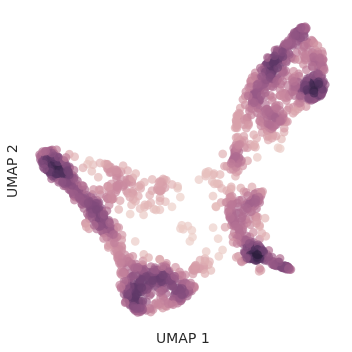

In [33]:
colon_UMAP = fcc_UMAP(colon.arcsinh_norm(), perplexity=30, seed=12)
colon_UMAP.plot()

In [34]:
colon_UMAP.plot(save_to='images/colon_UMAP.png', figsize=(6,6))

In [38]:
colon_UMAP.plot(color=colon.arcsinh_norm()[:,colon.gene_IDs=='Muc2'].flatten(), save_to='images/colon_Muc2_UMAP.png', figsize=(6,6))

In [39]:
colon_UMAP.plot(color=colon.arcsinh_norm()[:,colon.gene_IDs=='Krt20'].flatten(), save_to='images/colon_Krt20_UMAP.png', figsize=(6,6))

In [40]:
colon_UMAP.plot(color=colon.arcsinh_norm()[:,colon.gene_IDs=='Reg4'].flatten(), save_to='images/colon_Reg4_UMAP.png', figsize=(6,6))

R: 0.7193
EMD: 0.1034
KLD: 0.1164
Knn Pres.: 97.6161


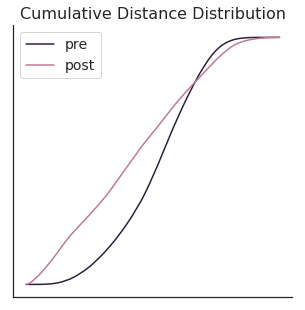

<Figure size 504x504 with 0 Axes>

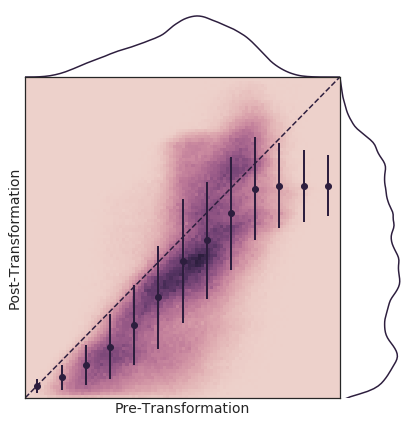

CPU times: user 1min 19s, sys: 12.8 s, total: 1min 32s
Wall time: 1min 31s


In [41]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=colon.distance_matrix(transform='arcsinh'), post=colon_UMAP.distance_matrix())
knn = knn_preservation(pre=colon.knn_graph(k, transform='arcsinh'), post=colon_UMAP.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.show()
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.show()

# dump outputs into dictionary
final_distance_stats['Colon']['R']['UMAP'], final_distance_stats['Colon']['EMD']['UMAP'], final_distance_stats['Colon']['KLD']['UMAP'], final_distance_stats['Colon']['Knn Pres.']['UMAP'] = mantel_stats[0], EMD, KLD, knn

---
# ZIFA
This method uses the zero-inflated negative binomial distribution to reduce RNA counts data to lower dimensions.  
Here, we will plug arcsinh-normalized counts data directly into ZIFA and compare results to the original, feature-selected dataset.

Filtering out all genes which are zero in more than 95.0% of samples. To change this, change p0_thresh.
Number of blocks has been set to 1
Running block zero-inflated factor analysis with N = 1654, D = 485, K = 2, n_blocks = 1
Block sizes [485]
Param change below threshold 1.000e-02 after 7 iterations


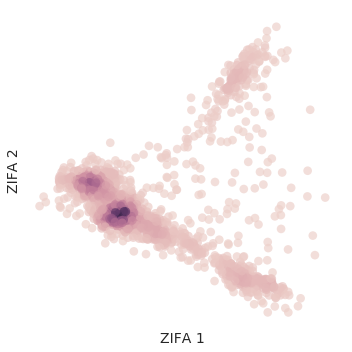

In [51]:
retina_ZIFA = fcc_ZIFA(retina.log2_norm(), K=2)
retina_ZIFA.plot()

R: 0.4611
EMD: 0.1403
KLD: 0.2737
Knn Pres.: 96.8422


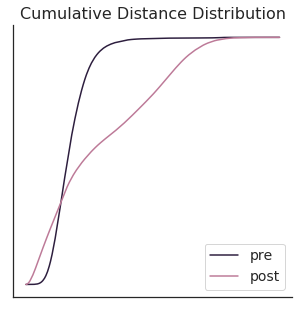

<Figure size 504x504 with 0 Axes>

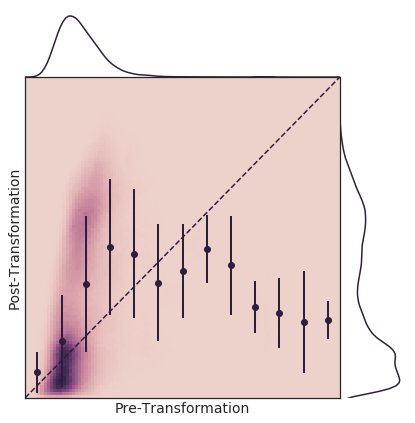

CPU times: user 1min 19s, sys: 12.6 s, total: 1min 32s
Wall time: 1min 31s


In [52]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=retina.distance_matrix(transform='log2'), post=retina_ZIFA.distance_matrix())
knn = knn_preservation(pre=retina.knn_graph(k, transform='log2'), post=retina_ZIFA.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.show()
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.show()

# dump outputs into dictionary
final_distance_stats['Retina']['R']['ZIFA'], final_distance_stats['Retina']['EMD']['ZIFA'], final_distance_stats['Retina']['KLD']['ZIFA'], final_distance_stats['Retina']['Knn Pres.']['ZIFA'] = mantel_stats[0], EMD, KLD, knn

Filtering out all genes which are zero in more than 95.0% of samples. To change this, change p0_thresh.
Number of blocks has been set to 1
Running block zero-inflated factor analysis with N = 1738, D = 492, K = 2, n_blocks = 1
Block sizes [492]
Param change below threshold 1.000e-02 after 4 iterations


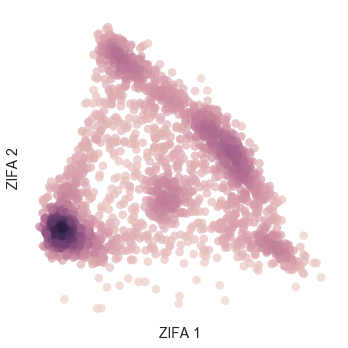

In [87]:
colon_ZIFA = fcc_ZIFA(colon.log2_norm(), K=2)
colon_ZIFA.plot()

R: 0.4802
EMD: 0.1613
KLD: 0.1621
Knn Pres.: 97.2802


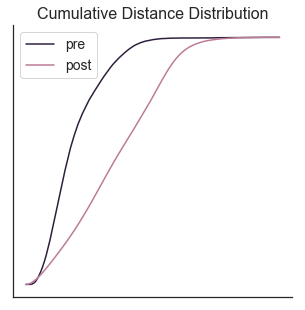

<Figure size 504x504 with 0 Axes>

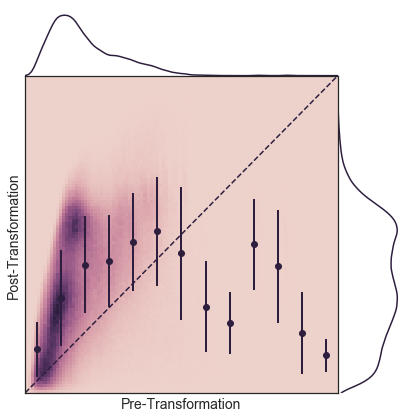

CPU times: user 1min 17s, sys: 14.8 s, total: 1min 32s
Wall time: 1min 32s


In [88]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=colon.distance_matrix(transform='log2'), post=colon_ZIFA.distance_matrix())
knn = knn_preservation(pre=colon.knn_graph(k, transform='log2'), post=colon_ZIFA.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.show()
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.show()

# dump outputs into dictionary
final_distance_stats['Colon']['R']['ZIFA'], final_distance_stats['Colon']['EMD']['ZIFA'], final_distance_stats['Colon']['KLD']['ZIFA'], final_distance_stats['Colon']['Knn Pres.']['ZIFA'] = mantel_stats[0], EMD, KLD, knn

---
# DCA
This method uses a deep count autoencoder to reduce RNA counts data to lower dimensions.  
Here, we will plug counts data directly into DCA and compare results to the original, feature-selected dataset.

In [89]:
%time retina_DCA = fcc_DCA(retina.counts, n_threads=4, norm=False)

DCA: Successfully preprocessed 500 genes and 1603 cells.
Instructions for updating:
Colocations handled automatically by placer.


2019-05-14 19:00:32,211 [WARNING] From /Users/cody/.virtualenvs/lau_lab/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Use tf.cast instead.


2019-05-14 19:00:33,312 [WARNING] From /Users/cody/.virtualenvs/lau_lab/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Calculating low dimensional representations...
Calculating reconstructions...
CPU times: user 26.2 s, sys: 4.49 s, total: 30.7 s
Wall time: 14.8 s


R: 0.9474
EMD: 0.0146
KLD: 0.0285
Knn Pres.: 97.5218


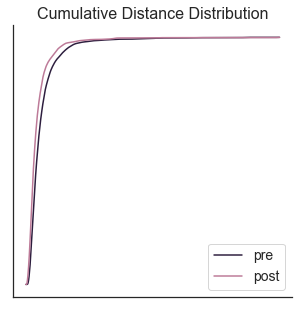

<Figure size 504x504 with 0 Axes>

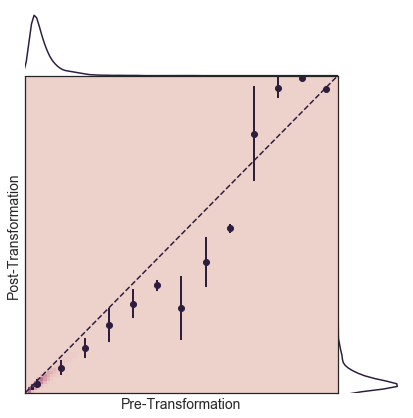

CPU times: user 1min 9s, sys: 13.2 s, total: 1min 22s
Wall time: 1min 23s


In [90]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=retina.distance_matrix(transform=None), post=retina_DCA.distance_matrix())
knn = knn_preservation(pre=retina.knn_graph(k, transform=None), post=retina_DCA.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.show()
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.show()

# dump outputs into dictionary
final_distance_stats['Retina']['R']['DCA'], final_distance_stats['Retina']['EMD']['DCA'], final_distance_stats['Retina']['KLD']['DCA'], final_distance_stats['Retina']['Knn Pres.']['DCA'] = mantel_stats[0], EMD, KLD, knn

In [91]:
%time colon_DCA = fcc_DCA(colon.counts, n_threads=4, norm=False)

DCA: Successfully preprocessed 500 genes and 1738 cells.
Calculating low dimensional representations...
Calculating reconstructions...
CPU times: user 55.1 s, sys: 9.46 s, total: 1min 4s
Wall time: 26.3 s


R: 0.9374
EMD: 0.0146
KLD: 0.0306
Knn Pres.: 98.2885


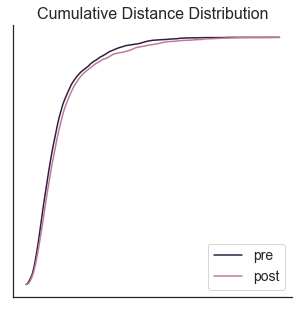

<Figure size 504x504 with 0 Axes>

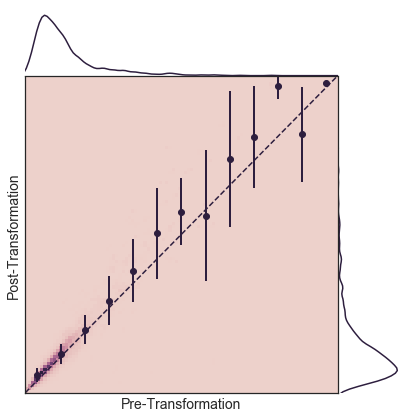

CPU times: user 1min 23s, sys: 14.8 s, total: 1min 38s
Wall time: 1min 39s


In [92]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=colon.distance_matrix(transform=None), post=colon_DCA.distance_matrix())
knn = knn_preservation(pre=colon.knn_graph(k, transform=None), post=colon_DCA.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.show()
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.show()

# dump outputs into dictionary
final_distance_stats['Colon']['R']['DCA'], final_distance_stats['Colon']['EMD']['DCA'], final_distance_stats['Colon']['KLD']['DCA'], final_distance_stats['Colon']['Knn Pres.']['DCA'] = mantel_stats[0], EMD, KLD, knn

---
# sc-VI
Here, we will plug counts data directly into sc-VI and compare results to the original, feature-selected dataset.

In [36]:
from scvi.dataset import CsvDataset, GeneExpressionDataset
import urllib
from scvi.models import *
from scvi.inference import UnsupervisedTrainer
use_batches=False

In [37]:
# Loading a local dataset into scVI
retina_scVI = CsvDataset('GSM1626793_P14Retina_1.processed.tsv', save_path='inputs/', new_n_genes=500, gene_by_cell=False, sep='\t')

File inputs/GSM1626793_P14Retina_1.processed.tsv already downloaded
Preprocessing dataset
Finished preprocessing dataset


In [38]:
vae = VAE(retina_scVI.nb_genes, n_batch=retina_scVI.n_batches * use_batches)
trainer = UnsupervisedTrainer(vae,
                              retina_scVI,
                              train_size=0.75,
                              use_cuda=True,
                              frequency=5)
trainer.train(n_epochs=400, lr=1e-3)

training: 100%|███████████████████████████████████████████████████████████████████████████████████| 400/400 [02:05<00:00,  3.05it/s]


In [39]:
full = trainer.create_posterior(trainer.model, retina_scVI, indices=np.arange(len(retina_scVI)))
latent, batch_indices, labels = full.sequential().get_latent()
batch_indices = batch_indices.ravel()

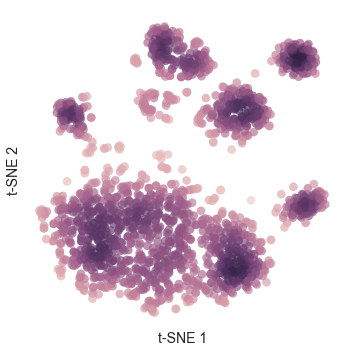

In [46]:
retina_scVI_tSNE = fcc_tSNE(matrix=latent, perplexity=30, seed=18)
retina_scVI_tSNE.plot()

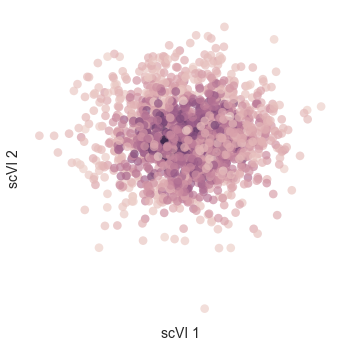

In [93]:
retina_scVI = DR(latent=latent.astype('double'), name='scVI')
retina_scVI.plot()

R: 0.3278
EMD: 0.3407
KLD: 0.2834
Knn Pres.: 96.6607


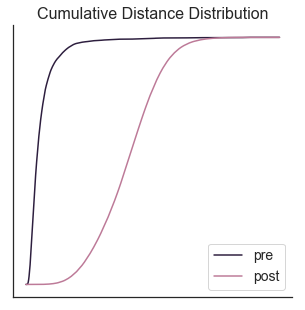

<Figure size 504x504 with 0 Axes>

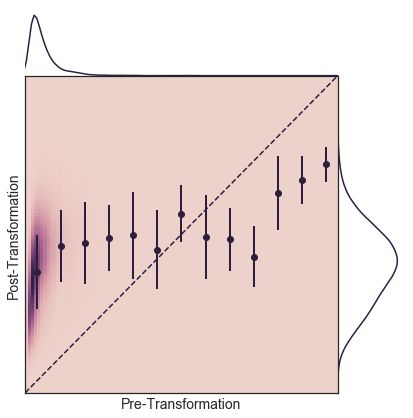

CPU times: user 1min 8s, sys: 11.7 s, total: 1min 20s
Wall time: 1min 20s


In [94]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=retina.distance_matrix(transform=None), post=retina_scVI.distance_matrix())
knn = knn_preservation(pre=retina.knn_graph(k, transform=None), post=retina_scVI.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.show()
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.show()

# dump outputs into dictionary
final_distance_stats['Retina']['R']['scVI'], final_distance_stats['Retina']['EMD']['scVI'], final_distance_stats['Retina']['KLD']['scVI'], final_distance_stats['Retina']['Knn Pres.']['scVI'] = mantel_stats[0], EMD, KLD, knn

In [95]:
# Loading a local dataset into scVI
colon_scVI = CsvDataset('GSM2743164_rep1_colon_rnaseq.processed.tsv', save_path='inputs/', new_n_genes=500, gene_by_cell=False, sep='\t')

File inputs/GSM2743164_rep1_colon_rnaseq.processed.tsv already downloaded
Preprocessing dataset
Finished preprocessing dataset


In [96]:
vae = VAE(colon_scVI.nb_genes, n_batch=colon_scVI.n_batches * use_batches)
trainer = UnsupervisedTrainer(vae,
                              colon_scVI,
                              train_size=0.75,
                              use_cuda=True,
                              frequency=5)
trainer.train(n_epochs=400, lr=1e-3)

training: 100%|███████████████████████████████████████████████████████████████████████████████████| 400/400 [02:20<00:00,  2.75it/s]


In [97]:
full = trainer.create_posterior(trainer.model, colon_scVI, indices=np.arange(len(colon_scVI)))
latent, batch_indices, labels = full.sequential().get_latent()
batch_indices = batch_indices.ravel()

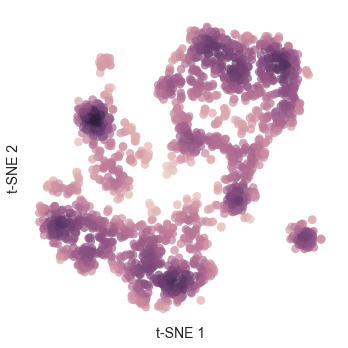

In [98]:
colon_scVI_tSNE = fcc_tSNE(matrix=latent, perplexity=30, seed=18)
colon_scVI_tSNE.plot()

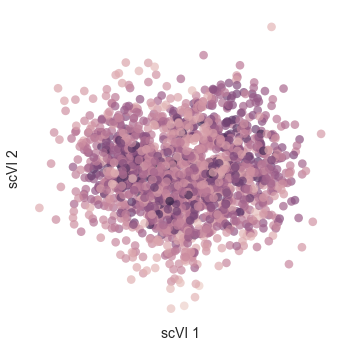

In [99]:
colon_scVI = DR(latent=latent.astype('double'), name='scVI')
colon_scVI.plot()

R: 0.2519
EMD: 0.2873
KLD: 0.2556
Knn Pres.: 97.1972


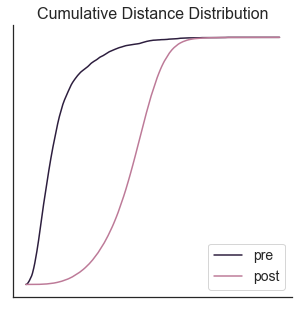

<Figure size 504x504 with 0 Axes>

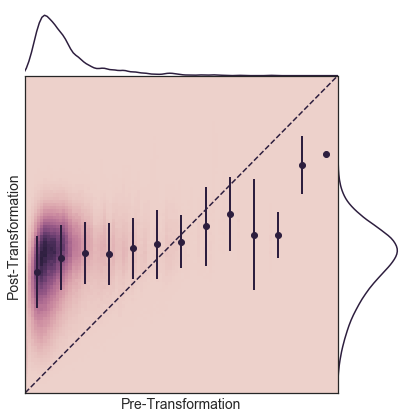

CPU times: user 1min 24s, sys: 14.7 s, total: 1min 38s
Wall time: 1min 39s


In [100]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=colon.distance_matrix(transform=None), post=colon_scVI.distance_matrix())
knn = knn_preservation(pre=colon.knn_graph(k, transform=None), post=colon_scVI.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.show()
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.show()

# dump outputs into dictionary
final_distance_stats['Colon']['R']['scVI'], final_distance_stats['Colon']['EMD']['scVI'], final_distance_stats['Colon']['KLD']['scVI'], final_distance_stats['Colon']['Knn Pres.']['scVI'] = mantel_stats[0], EMD, KLD, knn

---
# scvis
Here, we will plug counts data directly into scvis and compare results to the original, feature-selected dataset.

In [42]:
retina_scvis = DR.from_file(datafile='dev/scvis_out/retina/perplexity_30_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.tsv',
                            name='scvis')

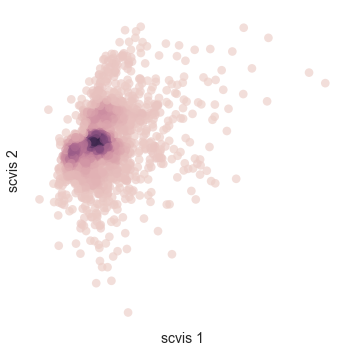

In [45]:
retina_scvis.plot()

R: 0.7762
EMD: 0.1075
KLD: 0.0953
Knn Pres.: 98.041


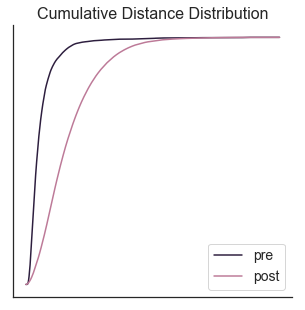

<Figure size 504x504 with 0 Axes>

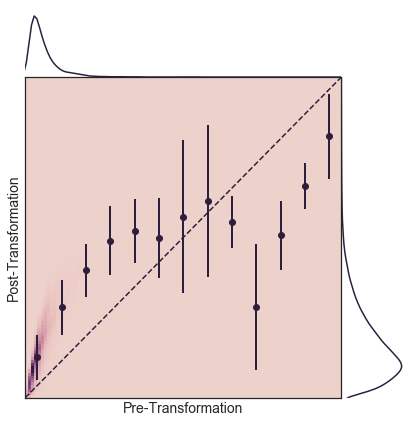

CPU times: user 1min 3s, sys: 11.3 s, total: 1min 14s
Wall time: 1min 14s


In [51]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=retina.distance_matrix(transform=None), post=retina_scvis.distance_matrix())
knn = knn_preservation(pre=retina.knn_graph(k, transform=None), post=retina_scvis.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.show()
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.show()

# dump outputs into dictionary
final_distance_stats['Retina']['R']['scvis'], final_distance_stats['Retina']['EMD']['scvis'], final_distance_stats['Retina']['KLD']['scvis'], final_distance_stats['Retina']['Knn Pres.']['scvis'] = mantel_stats[0], EMD, KLD, knn

In [49]:
colon_scvis = DR.from_file(datafile='dev/scvis_out/colon/perplexity_30_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.tsv',
                            name='scvis')

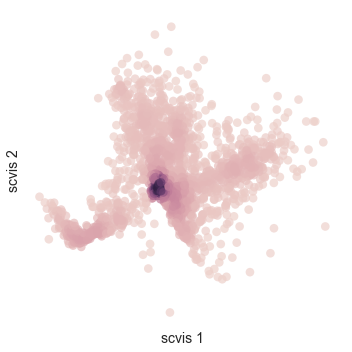

In [50]:
colon_scvis.plot()

R: 0.7126
EMD: 0.1062
KLD: 0.1142
Knn Pres.: 98.3118


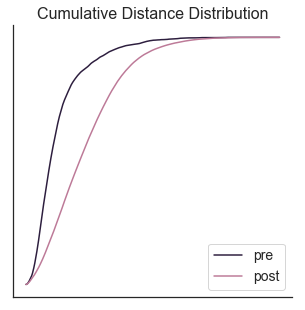

<Figure size 504x504 with 0 Axes>

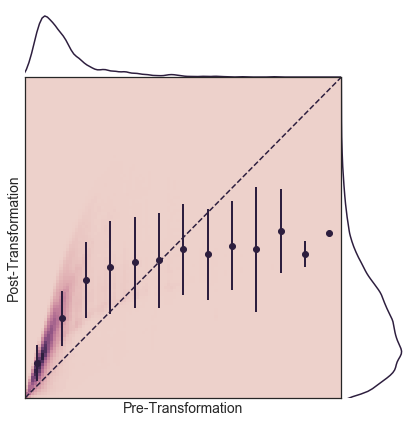

CPU times: user 1min 16s, sys: 13.2 s, total: 1min 29s
Wall time: 1min 29s


In [52]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=colon.distance_matrix(transform=None), post=colon_scvis.distance_matrix())
knn = knn_preservation(pre=colon.knn_graph(k, transform=None), post=colon_scvis.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.show()
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.show()

# dump outputs into dictionary
final_distance_stats['Colon']['R']['scvis'], final_distance_stats['Colon']['EMD']['scvis'], final_distance_stats['Colon']['KLD']['scvis'], final_distance_stats['Colon']['Knn Pres.']['scvis'] = mantel_stats[0], EMD, KLD, knn

---
# SIMLR
This method builds cell-cell similarity matrices to predict cluster number and assign cells to clusters based on similarity.
First, read in the `F` construct that consists of a c-dimensional output of length `n_cells`, where c is the number of expected clusters passed to SIMLR.  
Here, c was estimated using the `SIMLR_Estimate_Number_of_Clusters` function from the SIMLR package.

In [53]:
retina_SIMLR = DR.from_file('dev/Rmethods_out/retina_SIMLR_F.csv', name='SIMLR', labels=[None,0]) # read in low-dim space for comparison
retina_SIMLR_2D = DR.from_file('dev/Rmethods_out/retina_SIMLR_ydata.csv', name='SIMLR', labels=[None,0]) # read in 2D projection for visualization

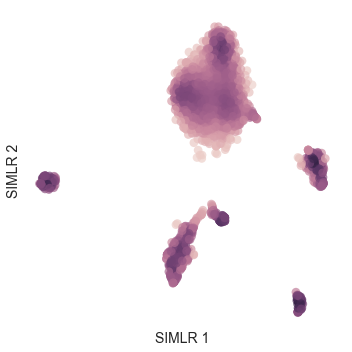

In [54]:
retina_SIMLR_2D.plot()

In [55]:
retina_SIMLR_2D.plot(save_to='retina_SIMLR.png')

In [56]:
retina_SIMLR_2D.plot(color=retina.arcsinh_norm()[:,retina.gene_IDs.str.contains('Rlbp1$')].flatten(), save_to='retina_Rlbp1_SIMLR.png')

In [108]:
retina_SIMLR_2D.plot(color=retina.arcsinh_norm()[:,retina.gene_IDs.str.contains('Pax6$')].flatten(), save_to='retina_Pax6_SIMLR.png')

In [109]:
retina_SIMLR_2D.plot(color=retina.arcsinh_norm()[:,retina.gene_IDs.str.contains('Opn1mw$')].flatten(), save_to='retina_Opn1mw_SIMLR.png')

R: 0.6016
EMD: 0.2297
KLD: 0.1998
Knn Pres.: 97.3331


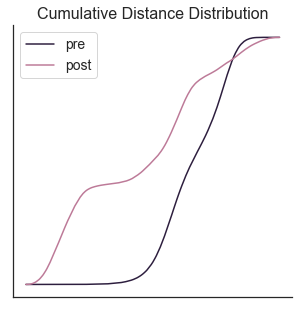

<Figure size 504x504 with 0 Axes>

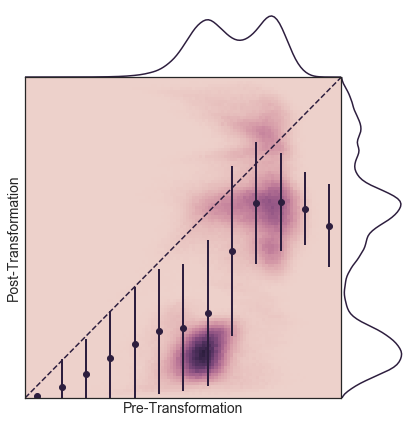

CPU times: user 1min 5s, sys: 12.1 s, total: 1min 17s
Wall time: 1min 17s


In [80]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=retina.distance_matrix(transform='arcsinh'), post=retina_SIMLR.distance_matrix())
knn = knn_preservation(pre=retina.knn_graph(k, transform='arcsinh'), post=retina_SIMLR.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.show()
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.show()

# dump outputs into dictionary
final_distance_stats['Retina']['R']['SIMLR'], final_distance_stats['Retina']['EMD']['SIMLR'], final_distance_stats['Retina']['KLD']['SIMLR'], final_distance_stats['Retina']['Knn Pres.']['SIMLR'] = mantel_stats[0], EMD, KLD, knn

In [58]:
colon_SIMLR = DR.from_file('dev/Rmethods_out/colon_SIMLR_F.csv', name='SIMLR', labels=[None,0]) # read in low-dim space for comparison
colon_SIMLR_2D = DR.from_file('dev/Rmethods_out/colon_SIMLR_ydata.csv', name='SIMLR', labels=[None,0]) # read in 2D projection for visualization

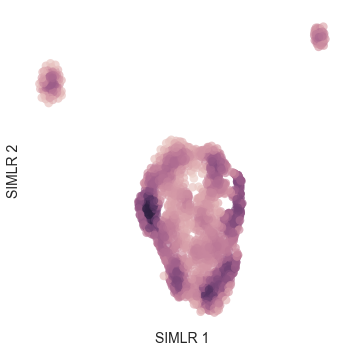

In [59]:
colon_SIMLR_2D.plot()

R: 0.5854
EMD: 0.1627
KLD: 0.0994
Knn Pres.: 97.8713


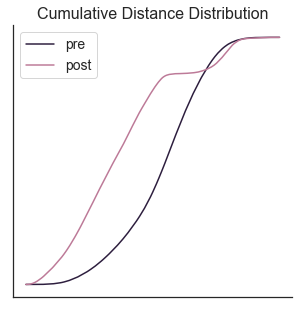

<Figure size 504x504 with 0 Axes>

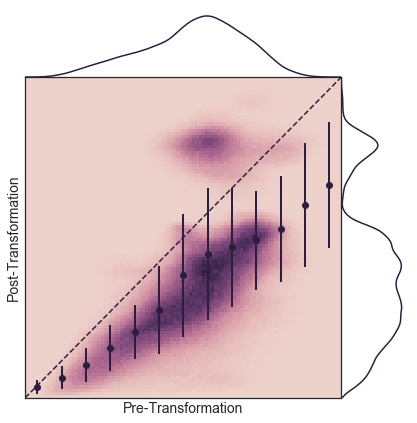

CPU times: user 1min 16s, sys: 12.3 s, total: 1min 29s
Wall time: 1min 28s


In [60]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=colon.distance_matrix(transform='arcsinh'), post=colon_SIMLR.distance_matrix())
knn = knn_preservation(pre=colon.knn_graph(k, transform='arcsinh'), post=colon_SIMLR.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.show()
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.show()

# dump outputs into dictionary
final_distance_stats['Colon']['R']['SIMLR'], final_distance_stats['Colon']['EMD']['SIMLR'], final_distance_stats['Colon']['KLD']['SIMLR'], final_distance_stats['Colon']['Knn Pres.']['SIMLR'] = mantel_stats[0], EMD, KLD, knn

---
### ZINB-WAVE

In [68]:
retina_ZINBWAVE = DR.from_file('dev/Rmethods_out/retina_ZINB-WAVE.csv', name='ZINB-WAVE', labels=[None,0])

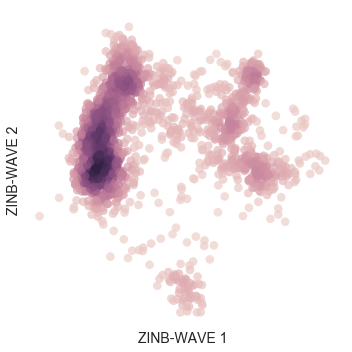

In [69]:
retina_ZINBWAVE.plot()

R: 0.2744
EMD: 0.2682
KLD: 0.3733
Knn Pres.: 96.7123


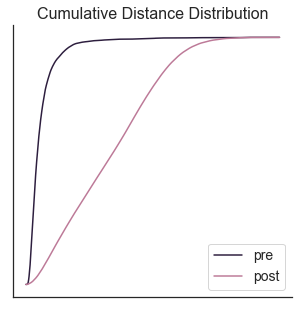

<Figure size 504x504 with 0 Axes>

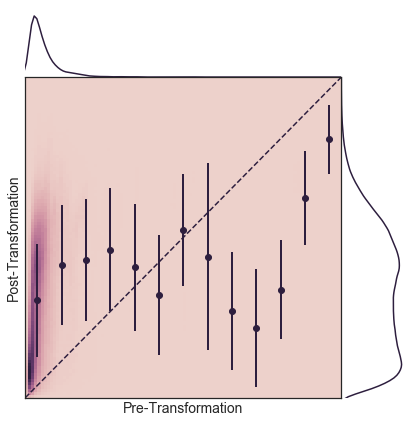

CPU times: user 1min 4s, sys: 13.1 s, total: 1min 17s
Wall time: 1min 17s


In [75]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=retina.distance_matrix(transform=None), post=retina_ZINBWAVE.distance_matrix())
knn = knn_preservation(pre=retina.knn_graph(k, transform=None), post=retina_ZINBWAVE.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.show()
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.show()

# dump outputs into dictionary
final_distance_stats['Retina']['R']['ZINB-WaVE'], final_distance_stats['Retina']['EMD']['ZINB-WaVE'], final_distance_stats['Retina']['KLD']['ZINB-WaVE'], final_distance_stats['Retina']['Knn Pres.']['ZINB-WaVE'] = mantel_stats[0], EMD, KLD, knn

In [71]:
colon_ZINBWAVE = DR.from_file('dev/Rmethods_out/colon_ZINB-WAVE.csv', name='ZINB-WAVE', labels=[None,0])

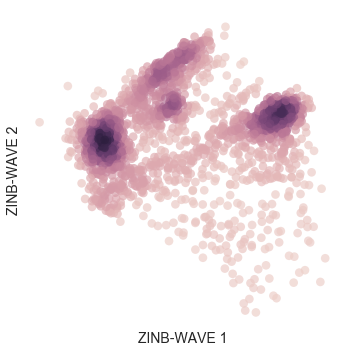

In [72]:
colon_ZINBWAVE.plot()

R: 0.2096
EMD: 0.1911
KLD: 0.344
Knn Pres.: 97.1428


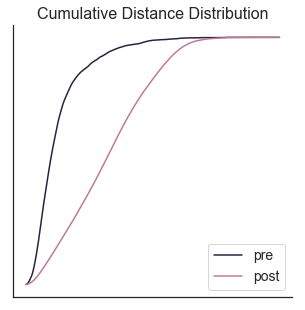

<Figure size 504x504 with 0 Axes>

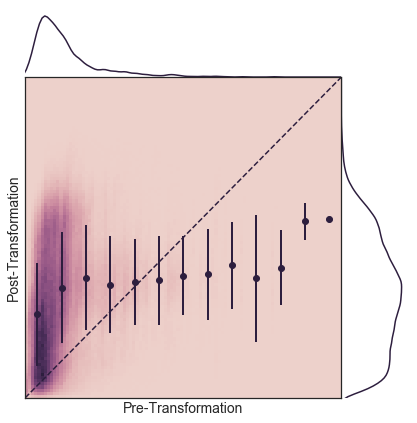

CPU times: user 1min 17s, sys: 14.5 s, total: 1min 32s
Wall time: 1min 32s


In [76]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=colon.distance_matrix(transform=None), post=colon_ZINBWAVE.distance_matrix())
knn = knn_preservation(pre=colon.knn_graph(k, transform=None), post=colon_ZINBWAVE.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.show()
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.show()

# dump outputs into dictionary
final_distance_stats['Colon']['R']['ZINB-WaVE'], final_distance_stats['Colon']['EMD']['ZINB-WaVE'], final_distance_stats['Colon']['KLD']['ZINB-WaVE'], final_distance_stats['Colon']['Knn Pres.']['ZINB-WaVE'] = mantel_stats[0], EMD, KLD, knn

---
### GLM-PCA

In [61]:
retina_GLMPCA = DR.from_file('dev/Rmethods_out/retina_GLM-PCA.csv', name='GLM-PC', labels=[None,0])

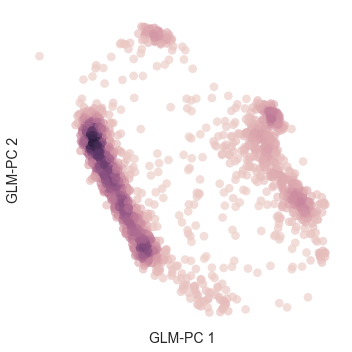

In [62]:
retina_GLMPCA.plot()

R: 0.2497
EMD: 0.2604
KLD: 0.4084
Knn Pres.: 96.6568


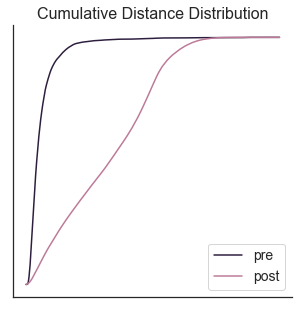

<Figure size 504x504 with 0 Axes>

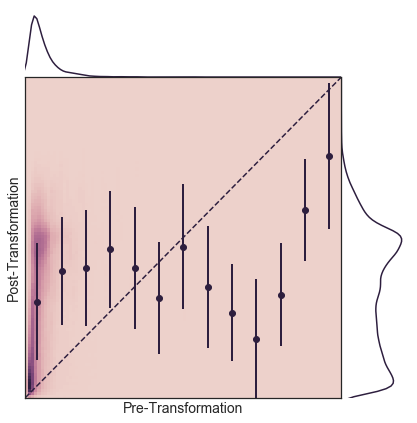

CPU times: user 1min 2s, sys: 11 s, total: 1min 13s
Wall time: 1min 13s


In [63]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=retina.distance_matrix(transform=None), post=retina_GLMPCA.distance_matrix())
knn = knn_preservation(pre=retina.knn_graph(k, transform=None), post=retina_GLMPCA.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.show()
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.show()

# dump outputs into dictionary
final_distance_stats['Retina']['R']['GLM-PCA'], final_distance_stats['Retina']['EMD']['GLM-PCA'], final_distance_stats['Retina']['KLD']['GLM-PCA'], final_distance_stats['Retina']['Knn Pres.']['GLM-PCA'] = mantel_stats[0], EMD, KLD, knn

In [64]:
colon_GLMPCA = DR.from_file('dev/Rmethods_out/colon_GLM-PCA.csv', name='GLM-PC', labels=[None,0])

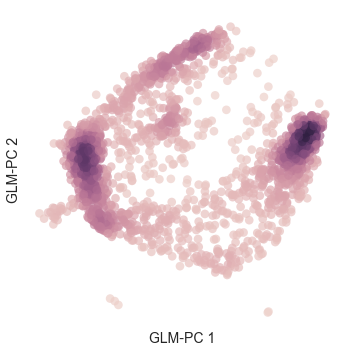

In [65]:
colon_GLMPCA.plot()

R: 0.3024
EMD: 0.2674
KLD: 0.3057
Knn Pres.: 97.1596


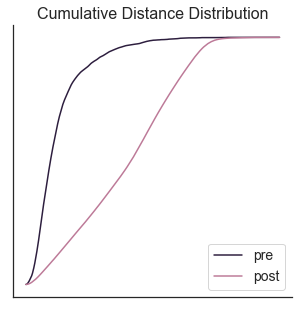

<Figure size 504x504 with 0 Axes>

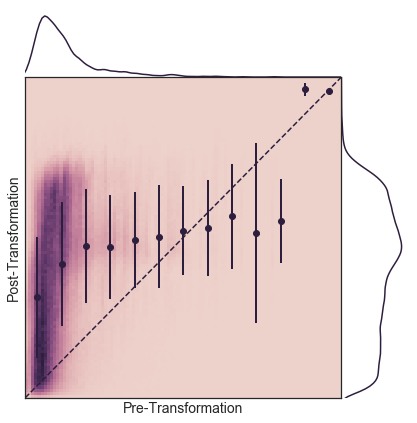

CPU times: user 1min 16s, sys: 14 s, total: 1min 30s
Wall time: 1min 30s


In [74]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=colon.distance_matrix(transform=None), post=colon_GLMPCA.distance_matrix())
knn = knn_preservation(pre=colon.knn_graph(k, transform=None), post=colon_GLMPCA.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.show()
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.show()

# dump outputs into dictionary
final_distance_stats['Colon']['R']['GLM-PCA'], final_distance_stats['Colon']['EMD']['GLM-PCA'], final_distance_stats['Colon']['KLD']['GLM-PCA'], final_distance_stats['Colon']['Knn Pres.']['GLM-PCA'] = mantel_stats[0], EMD, KLD, knn

---
### Summary Metrics

In [112]:
retina_sum = pd.DataFrame(final_distance_stats['Retina'])

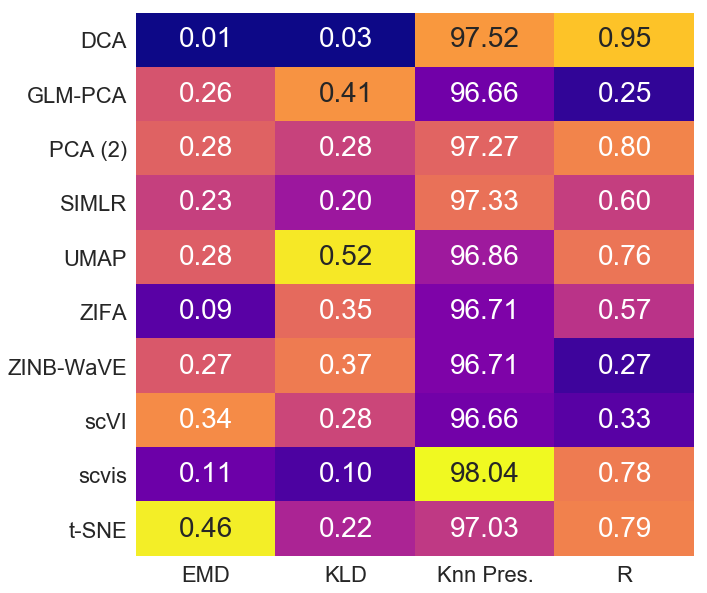

In [113]:
retina_norm=(retina_sum-retina_sum.mean())/retina_sum.std()
sns.set(font_scale=2)
plt.figure(figsize=(10,10))
sns.heatmap(retina_norm, annot=retina_sum, cmap='plasma', robust=True, annot_kws={"size": 28}, fmt='.2f', cbar=False)

In [114]:
colon_sum = pd.DataFrame(final_distance_stats['Colon'])

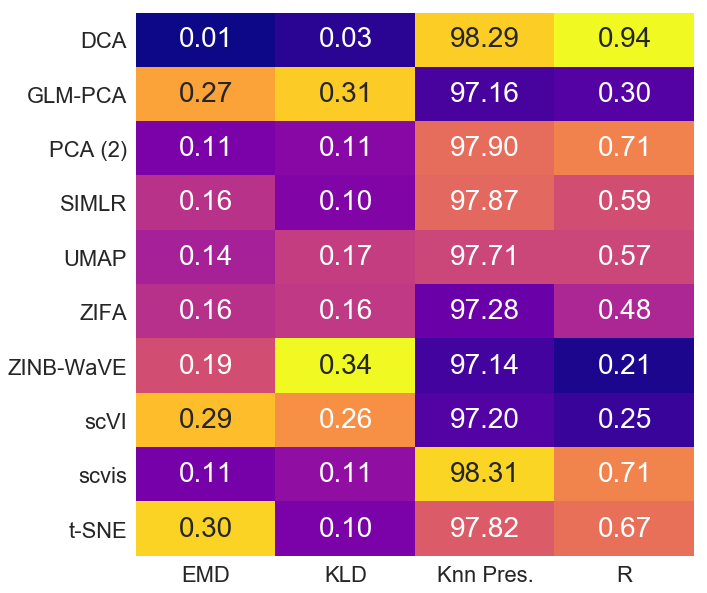

In [115]:
colon_norm=(colon_sum-colon_sum.mean())/colon_sum.std()
sns.set(font_scale=2)
plt.figure(figsize=(10,10))
sns.heatmap(colon_norm, annot=colon_sum, cmap='plasma', robust=True, annot_kws={"size": 28}, fmt='.2f', cbar=False)